In [16]:
!pip install gymnasium

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import gymnasium as gym

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

Эпизод 900
Награда: -16.00
Средняя: -1.95
Эпсилон: 0.122


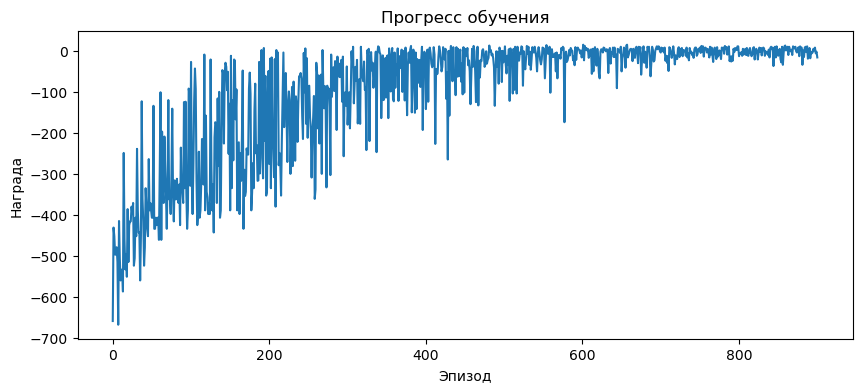


Готово!
Финальная средняя: 1.29


In [17]:
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

print(f"Taxi-v3 создана")
print(f"Действий: {n_actions}")

class QLearningAgent():
    def __init__(self, alpha, epsilon, discount, getLegalActions):
        self.getLegalActions = getLegalActions
        self._qValues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        if not (state in self._qValues) or not (action in self._qValues[state]):
            return 0.0
        return self._qValues[state][action]

    def setQValue(self, state, action, value):
        self._qValues[state][action] = value

    def getValue(self, state):
        possibleActions = self.getLegalActions(state)
        if not possibleActions:
            return 0.0
        return max(self.getQValue(state, a) for a in possibleActions)

    def getPolicy(self, state):
        possibleActions = self.getLegalActions(state)
        if not possibleActions:
            return None
        
        best_value = -float('inf')
        best_action = None
        for action in possibleActions:
            value = self.getQValue(state, action)
            if value > best_value:
                best_value = value
                best_action = action
        return best_action

    def getAction(self, state):
        possibleActions = self.getLegalActions(state)
        if not possibleActions:
            return None
        
        if random.random() < self.epsilon:
            return random.choice(possibleActions)
        else:
            return self.getPolicy(state)

    def update(self, state, action, nextState, reward):
        old_q = self.getQValue(state, action)
        next_q = self.getValue(nextState)
        new_q = old_q + self.alpha * (reward + self.discount * next_q - old_q)
        self.setQValue(state, action, new_q)

def play_and_train(env, agent, t_max=1000):
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        a = agent.getAction(s)
        next_s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        
        agent.update(s, a, next_s, r)
        s = next_s
        total_reward += r
        if done:
            break
    return total_reward

agent = QLearningAgent(
    alpha=0.2,
    epsilon=0.3,
    discount=0.95,
    getLegalActions=lambda s: range(n_actions)
)

rewards = []
for i in range(1000):
    reward = play_and_train(env, agent)
    rewards.append(reward)
    agent.epsilon = max(0.01, agent.epsilon * 0.999)
    
    if i % 100 == 0:
        clear_output(wait=True)
        avg_reward = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Эпизод {i}")
        print(f"Награда: {reward:.2f}")
        print(f"Средняя: {avg_reward:.2f}")
        print(f"Эпсилон: {agent.epsilon:.3f}")
        
        plt.figure(figsize=(10, 4))
        plt.plot(rewards)
        plt.xlabel('Эпизод')
        plt.ylabel('Награда')
        plt.title('Прогресс обучения')
        plt.show()

print("\nГотово!")
print(f"Финальная средняя: {np.mean(rewards[-100:]):.2f}")

## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

Первое состояние: [-0.0026552  -0.00166201 -0.00325877 -0.02316494]
Собрано 2165 состояний
Диапазоны: min=[-0.38720372 -1.902757   -0.2522726  -2.8483374 ], max=[0.34890082 1.7911354  0.25572664 2.8304493 ]


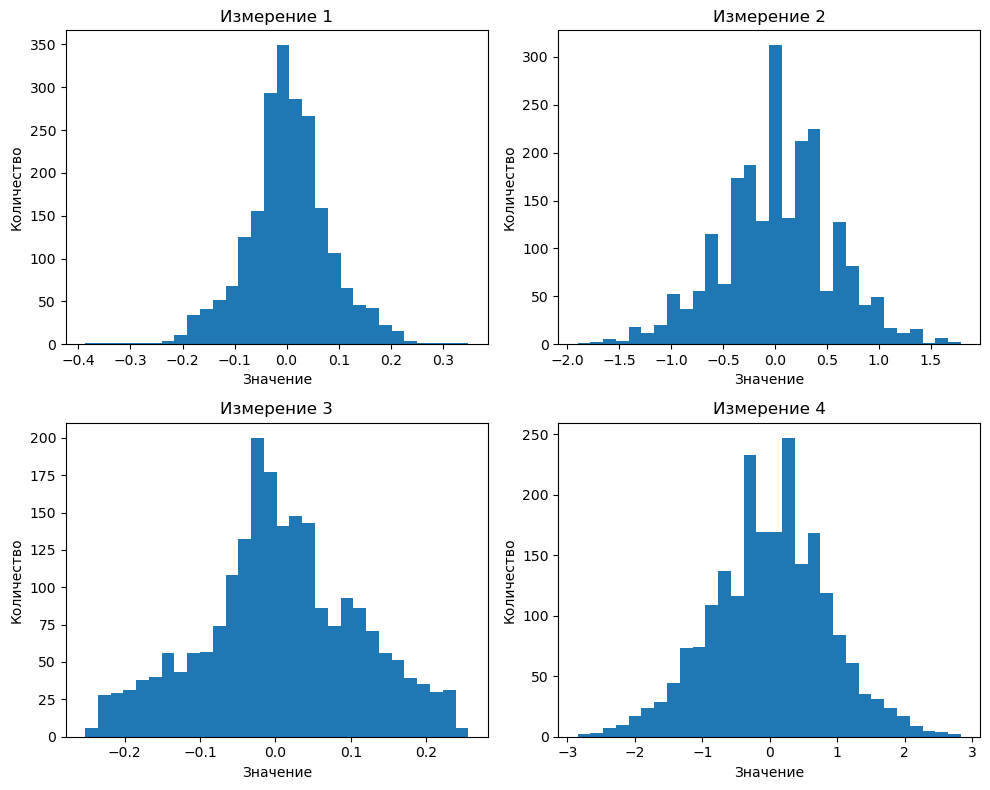

In [18]:
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state, _ = env.reset()
print("Первое состояние:", state)

states = []
for _ in range(100):
    state, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        states.append(next_state)
        if done:
            break

states = np.array(states)
print(f"Собрано {len(states)} состояний")
print(f"Диапазоны: min={states.min(axis=0)}, max={states.max(axis=0)}")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i in range(4):
    ax = axes[i//2, i%2]
    ax.hist(states[:, i], bins=30)
    ax.set_title(f'Измерение {i+1}')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()

### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

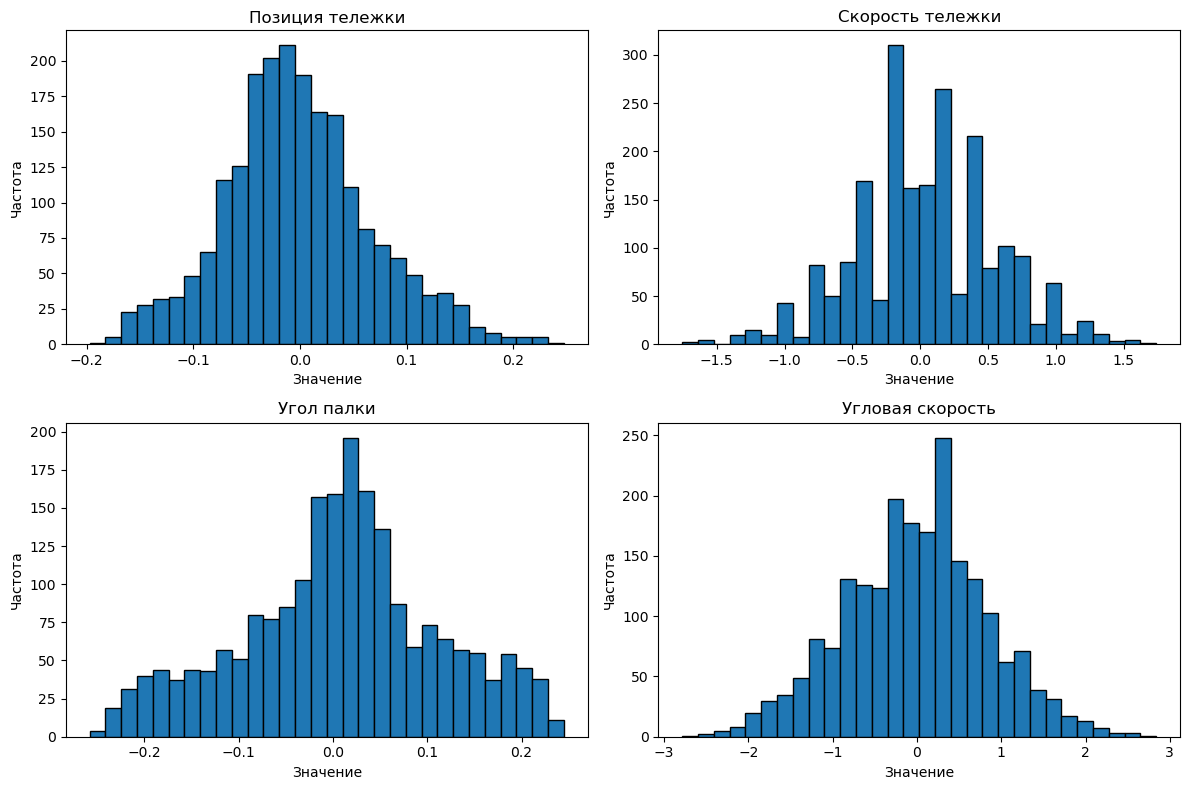

Собрано состояний: 2104
Min значения: [-0.19739592 -1.7561439  -0.25803998 -2.7848916 ]
Max значения: [0.2474374 1.7400372 0.2446578 2.8389392]


In [19]:
states = []
for _ in range(100):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    done = False
    while not done:
        action = env.action_space.sample()
        step_result = env.step(action)
        
        if len(step_result) == 5:
            next_state, _, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, _, done, _ = step_result
            
        states.append(next_state)
        if done:
            break

states = np.array(states)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
titles = ['Позиция тележки', 'Скорость тележки', 'Угол палки', 'Угловая скорость']

for i in range(4):
    ax = axes[i//2, i%2]
    ax.hist(states[:, i], bins=30, edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

print(f"Собрано состояний: {len(states)}")
print(f"Min значения: {states.min(axis=0)}")
print(f"Max значения: {states.max(axis=0)}")

## Binarize environment

In [20]:
from gymnasium.core import ObservationWrapper

class Binarizer(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.bins = [
            np.linspace(-2.4, 2.4, 8),
            np.linspace(-3.0, 3.0, 6),
            np.linspace(-0.2, 0.2, 8),
            np.linspace(-3.0, 3.0, 6)
        ]

    def to_bin(self, value, bins):
        return np.digitize(value, bins)

    def observation(self, state):
        binned_state = tuple(
            self.to_bin(state[i], self.bins[i]) 
            for i in range(4)
        )
        return binned_state

env = Binarizer(gym.make("CartPole-v1"))
state, _ = env.reset()
print("Бинаризованное состояние:", state)

Бинаризованное состояние: (np.int64(4), np.int64(3), np.int64(3), np.int64(3))


## Learn

Эпизод 4800
Эпсилон: 0.045
Средняя награда: 129.85


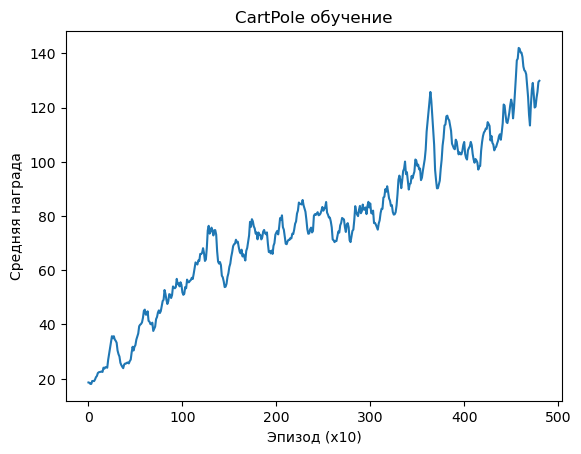

In [21]:
def play_and_train_binarized(env, agent, t_max=10000):
    total_reward = 0.0
    state, _ = env.reset()

    for t in range(t_max):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        agent.update(state, action, next_state, reward)
        
        state = next_state
        total_reward += reward
        if done:
            break
            
    return total_reward

agent = QLearningAgent(
    alpha=0.1,
    epsilon=0.5,
    discount=0.95,
    getLegalActions=lambda s: range(n_actions)
)

rewards = []
rewBuf = []
for i in range(500):
    for _ in range(10):
        reward = play_and_train_binarized(env, agent)
        rewards.append(reward)
    agent.epsilon *= 0.995
    
    if len(rewards) >= 100:
        rewBuf.append(np.mean(rewards[-100:]))
    else:
        rewBuf.append(np.mean(rewards))
    
    if i % 20 == 0:
        clear_output(True)
        print(f"Эпизод {i*10}")
        print(f"Эпсилон: {agent.epsilon:.3f}")
        print(f"Средняя награда: {rewBuf[-1]:.2f}")
        plt.plot(rewBuf)
        plt.xlabel('Эпизод (x10)')
        plt.ylabel('Средняя награда')
        plt.title('CartPole обучение')
        plt.show()

if rewBuf[-1] > 195:
    print("Победа!")

## 4. Experience replay (5 pts)

In [22]:
import random

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) < self._maxsize:
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size):
        indices = np.random.randint(0, len(self._storage), size=batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for i in indices:
            data = self._storage[i]
            states.append(data[0])
            actions.append(data[1])
            rewards.append(data[2])
            next_states.append(data[3])
            dones.append(data[4])
            
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

Some tests to make sure your buffer works right

In [23]:
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)[0][0] == 0
replay.add(*obj2)
assert len(replay._storage)==2
replay.add(*obj2)
assert len(replay._storage)==2
assert np.unique(replay.sample(100)[0])[0] == 5
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert np.unique(replay.sample(100)[0])[0] == 0
print("Успех!")

Успех!


Now let's use this buffer to improve training:

Итерация 1900
Эпсилон: 0.192
Средняя награда: 13.66


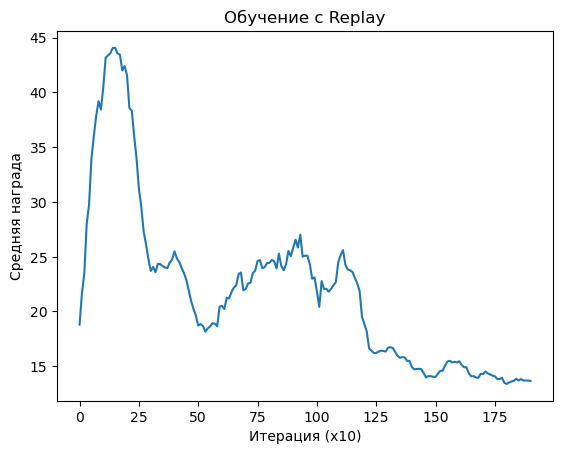

In [24]:
env = Binarizer(gym.make('CartPole-v1'))
n_actions = env.action_space.n

class QLearningAgent():
    def __init__(self, alpha, epsilon, discount, getLegalActions):
        self.getLegalActions = getLegalActions
        self._qValues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        state = tuple(state) if isinstance(state, np.ndarray) else state
        if not (state in self._qValues) or not (action in self._qValues[state]):
            return 0.0
        return self._qValues[state][action]

    def setQValue(self, state, action, value):
        state = tuple(state) if isinstance(state, np.ndarray) else state
        self._qValues[state][action] = value

    def getValue(self, state):
        possibleActions = self.getLegalActions(state)
        if not possibleActions:
            return 0.0
        return max(self.getQValue(state, a) for a in possibleActions)

    def getPolicy(self, state):
        possibleActions = self.getLegalActions(state)
        if not possibleActions:
            return None
        
        best_value = -float('inf')
        best_action = None
        for action in possibleActions:
            value = self.getQValue(state, action)
            if value > best_value:
                best_value = value
                best_action = action
        return best_action

    def getAction(self, state):
        possibleActions = self.getLegalActions(state)
        if not possibleActions:
            return None
        
        if random.random() < self.epsilon:
            return random.choice(possibleActions)
        else:
            return self.getPolicy(state)

    def update(self, state, action, nextState, reward):
        old_q = self.getQValue(state, action)
        next_q = self.getValue(nextState)
        new_q = old_q + self.alpha * (reward + self.discount * next_q - old_q)
        self.setQValue(state, action, new_q)

agent = QLearningAgent(
    alpha=0.1,
    epsilon=0.5,
    discount=0.95,
    getLegalActions=lambda s: range(n_actions)
)

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        obs_t = tuple(obs_t) if isinstance(obs_t, np.ndarray) else obs_t
        obs_tp1 = tuple(obs_tp1) if isinstance(obs_tp1, np.ndarray) else obs_tp1
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) < self._maxsize:
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size):
        indices = np.random.randint(0, len(self._storage), size=batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for i in indices:
            data = self._storage[i]
            states.append(data[0])
            actions.append(data[1])
            rewards.append(data[2])
            next_states.append(data[3])
            dones.append(data[4])
            
        return states, actions, rewards, next_states, dones

replay = ReplayBuffer(10000)

def play_and_train_with_replay(env, agent, replay, t_max=500, batch_size=32):
    total_reward = 0.0
    state, _ = env.reset()
    
    for t in range(t_max):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        replay.add(state, action, reward, next_state, done)
        
        if len(replay) >= batch_size:
            states, actions, rewards, next_states, dones = replay.sample(batch_size)
            for i in range(batch_size):
                agent.update(states[i], actions[i], next_states[i], rewards[i])
        
        state = next_state
        total_reward += reward
        if done:
            break
    
    return total_reward

rewards = []
rewBuf = []
for i in range(200):
    for _ in range(10):
        reward = play_and_train_with_replay(env, agent, replay, batch_size=64)
        rewards.append(reward)
    agent.epsilon *= 0.995
    
    if len(rewards) >= 100:
        rewBuf.append(np.mean(rewards[-100:]))
    else:
        rewBuf.append(np.mean(rewards))
    
    if i % 10 == 0:
        clear_output(True)
        print(f"Итерация {i*10}")
        print(f"Эпсилон: {agent.epsilon:.3f}")
        print(f"Средняя награда: {rewBuf[-1]:.2f}")
        plt.plot(rewBuf)
        plt.xlabel('Итерация (x10)')
        plt.ylabel('Средняя награда')
        plt.title('Обучение с Replay')
        plt.show()
        
        if rewBuf[-1] > 195:
            print("Победа!")
            break